---
## Section 1: Setup & Configuration

In [1]:
# ==============================================================================
# IMPORTS (Standard Libraries Only - No Local Modules)
# ==============================================================================
import os
import glob
import warnings
import copy
from dataclasses import dataclass, field
from typing import List, Dict, Tuple, Optional, Any, Union
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("All imports successful!")

All imports successful!


### 1.1 Pipeline Configuration (Single Source of Truth)

All project configurations including paths, hyperparameters, training settings, data splits, and feature definitions consolidated into a single dataclass.

In [2]:
# ==============================================================================
# PIPELINE CONFIGURATION (Single Source of Truth)
# ==============================================================================

@dataclass
class PipelineConfig:
    """
    Central configuration for the Hydrology Deep Learning Pipeline.
    
    All parameters are consolidated here - no scattered global variables.
    Instantiate with custom values for easy experimentation:
    
        cfg = PipelineConfig(num_basins=10, epochs=20, hidden_dim_t1=64)
    """
    # === EXPERIMENT SETTINGS ===
    num_basins: int = 5              # 0 = use ALL basins, >0 = limit for quick testing
    use_static: bool = True          # Whether to include static catchment attributes
    
    # === TRAINING HYPERPARAMETERS ===
    epochs: int = 10
    batch_size: int = 256
    learning_rate: float = 0.001
    dropout: float = 0.2
    
    # === TASK 1 MODEL ARCHITECTURE ===
    hidden_dim_t1: int = 32          # Hidden dimension for Task 1 LSTM (smaller for regression)
    use_bidirectional_t1: bool = True     # Use bidirectional LSTM for Task 1
    use_self_attention_t1: bool = True    # Apply self-attention after LSTM for Task 1
    use_layer_norm_t1: bool = True        # Apply LayerNorm in Task 1 model
    num_attention_heads_t1: int = 4       # Number of heads for multi-head self-attention
    
    # === TASK 2 MODEL ARCHITECTURE ===
    hidden_dim_t2: int = 64          # Hidden dimension for Task 2 Seq2Seq (larger for seq2seq)
    use_bidirectional_encoder_t2: bool = True  # Use bidirectional encoder for Task 2
    use_self_attention_t2: bool = True         # Apply self-attention in encoder
    use_layer_norm_t2: bool = True             # Apply LayerNorm in Task 2 model
    num_attention_heads_t2: int = 4            # Number of heads for encoder self-attention
    teacher_forcing_ratio: float = 0.5         # Initial teacher forcing probability
    tf_decay: bool = True                      # Whether to decay TF ratio over epochs
    
    # === EARLY STOPPING ===
    patience: int = 5                # Stop if val_loss doesn't improve for this many epochs
    
    # === VISUALIZATION ===
    show_plots: bool = True          # Set False to suppress plots during batch experiments
    
    # === DEVICE ===
    device_type: str = 'auto'        # 'auto', 'cuda', 'cpu'
    
    # === PATHS ===
    base_dir: str = './basin_dataset_public'
    results_dir: str = './results'
    
    # === SEQUENCE PARAMETERS ===
    seq_length: int = 60             # Lookback window (days)
    predict_horizon: int = 2         # For Task 1: Predict t + k
    predict_steps: int = 5           # For Task 2: Predict sequence t+1...t+5
    
    # === DATA SPLIT (Hydrological Years) ===
    train_start: str = '1980-10-01'
    train_end: str = '1995-09-30'
    val_start: str = '1995-10-01'
    val_end: str = '2000-09-30'
    test_start: str = '2000-10-01'
    test_end: str = '2010-09-30'
    
    # === FEATURE SELECTION ===
    dynamic_features: List[str] = field(default_factory=lambda: [
        'PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp',   # Original Forcing
        'PRCP_roll3', 'PRCP_roll7',             # Rolling Stats
        'Q_lag1', 'Q_lag2', 'Q_lag3'            # Lag Features
    ])
    
    static_features: List[str] = field(default_factory=lambda: [
        'area_gages2',  # Catchment Area (Will be Log transformed)
        'elev_mean',    # Mean Elevation
        'slope_mean',   # Topography
        'sand_frac',    # Soil Type
        'clay_frac',    # Soil Type
        'frac_forest',  # Vegetation
        'lai_max',      # Leaf Area Index
        'p_mean',       # Long-term climate
        'aridity'       # Climate Index
    ])
    
    target: str = 'Q_cms'
    
    # === CONSTANTS ===
    cfs_to_cms: float = 0.0283168    # Cubic feet/sec to cubic meters/sec
    epsilon: float = 1e-6            # Small constant for numerical stability
    
    # === DERIVED PATHS (computed in __post_init__) ===
    forcing_dir: str = field(init=False)
    flow_dir: str = field(init=False)
    meta_dir: str = field(init=False)
    bad_basins_file: str = field(init=False)
    device: torch.device = field(init=False)
    
    def __post_init__(self):
        """Compute derived attributes after initialization."""
        self.forcing_dir = os.path.join(self.base_dir, 'basin_mean_forcing', 'nldas')
        self.flow_dir = os.path.join(self.base_dir, 'usgs_streamflow')
        self.meta_dir = self.base_dir  # Static attribute files are in the base directory
        self.bad_basins_file = os.path.join(self.base_dir, 'basin_size_errors_10_percent.txt')
        
        # Configure device
        if self.device_type == 'auto':
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        else:
            self.device = torch.device(self.device_type)
    
    def print_config(self):
        """Pretty print the configuration."""
        print("=" * 60)
        print("PIPELINE CONFIGURATION")
        print("=" * 60)
        print(f"\n--- Experiment Settings ---")
        print(f"Number of Basins: {self.num_basins} {'(ALL)' if self.num_basins == 0 else '(limited)'}")
        print(f"Use Static Features: {self.use_static}")
        print(f"Show Plots: {self.show_plots}")
        
        print(f"\n--- Training Hyperparameters ---")
        print(f"Epochs: {self.epochs}")
        print(f"Batch Size: {self.batch_size}")
        print(f"Learning Rate: {self.learning_rate}")
        print(f"Dropout: {self.dropout}")
        print(f"Early Stopping Patience: {self.patience}")
        
        print(f"\n--- Task 1 Model Architecture ---")
        print(f"Hidden Dimension: {self.hidden_dim_t1}")
        print(f"Bidirectional LSTM: {self.use_bidirectional_t1}")
        print(f"Self-Attention: {self.use_self_attention_t1}", end="")
        if self.use_self_attention_t1:
            print(f" (Heads: {self.num_attention_heads_t1})")
        else:
            print()
        print(f"Layer Normalization: {self.use_layer_norm_t1}")
        
        print(f"\n--- Task 2 Model Architecture ---")
        print(f"Hidden Dimension: {self.hidden_dim_t2}")
        print(f"Bidirectional Encoder: {self.use_bidirectional_encoder_t2}")
        print(f"Encoder Self-Attention: {self.use_self_attention_t2}", end="")
        if self.use_self_attention_t2:
            print(f" (Heads: {self.num_attention_heads_t2})")
        else:
            print()
        print(f"Layer Normalization: {self.use_layer_norm_t2}")
        print(f"Teacher Forcing: {self.teacher_forcing_ratio} (Decay: {self.tf_decay})")
        
        print(f"\n--- Device ---")
        print(f"Device: {self.device}")
        if self.device.type == 'cuda':
            print(f"GPU: {torch.cuda.get_device_name(0)}")
        
        print(f"\n--- Sequence Parameters ---")
        print(f"Sequence Length: {self.seq_length} days")
        print(f"Prediction Horizon (Task 1): t+{self.predict_horizon}")
        print(f"Prediction Steps (Task 2): {self.predict_steps} steps")
        
        print(f"\n--- Data Split (Hydrological Years) ---")
        print(f"Train: {self.train_start} to {self.train_end}")
        print(f"Val:   {self.val_start} to {self.val_end}")
        print(f"Test:  {self.test_start} to {self.test_end}")
        
        print(f"\n--- Features ---")
        print(f"Dynamic Features ({len(self.dynamic_features)}): {self.dynamic_features}")
        print(f"Static Features ({len(self.static_features)}): {self.static_features}")
        print(f"Target: {self.target}")
        
        print(f"\n--- Paths ---")
        print(f"Base Directory: {self.base_dir}")
        print(f"Results Directory: {self.results_dir}")

print("PipelineConfig dataclass defined.")

PipelineConfig dataclass defined.


### 1.2 Pipeline Results Container

A dataclass to hold all outputs from the pipeline run: models, metrics, predictions, and training history.

In [3]:
# ==============================================================================
# PIPELINE RESULTS CONTAINER
# ==============================================================================

@dataclass
class PipelineResults:
    """
    Container for all outputs from a pipeline run.
    
    This allows clean returns from run_full_pipeline() and easy access
    to all results for further analysis or saving.
    """
    # === MODELS ===
    model_t1: nn.Module                    # Trained Task 1 LSTM model
    model_t2: nn.Module                    # Trained Task 2 Seq2Seq model
    
    # === TRAINING HISTORY ===
    history_t1: Dict[str, List[float]]     # {'train_loss': [...], 'val_loss': [...]}
    history_t2: Dict[str, List[float]]     # Same structure
    
    # === METRICS ===
    metrics_t1: Dict[str, float]           # {'MSE': ..., 'RMSE': ..., 'NSE': ..., 'R2': ...}
    metrics_t2: Dict[str, float]           # Same structure (averaged over 5 steps)
    metrics_t2_per_step: Dict[int, Dict[str, float]]  # {1: {...}, 2: {...}, ...} per horizon
    
    # === PREDICTIONS ===
    predictions_t1: np.ndarray             # (N_test,) predictions
    targets_t1: np.ndarray                 # (N_test,) ground truth
    predictions_t2: np.ndarray             # (N_test, 5) predictions
    targets_t2: np.ndarray                 # (N_test, 5) ground truth
    
    # === DATA INFO ===
    basin_ids: List[str]                   # List of basin IDs used
    preprocessor: Any                      # Fitted preprocessor (for denormalization)
    
    def summary(self):
        """Print a summary of the pipeline results."""
        print("=" * 60)
        print("PIPELINE RESULTS SUMMARY")
        print("=" * 60)
        
        print(f"\n--- Data ---")
        print(f"Number of basins: {len(self.basin_ids)}")
        print(f"Test samples (Task 1): {len(self.predictions_t1)}")
        print(f"Test samples (Task 2): {len(self.predictions_t2)}")
        
        print(f"\n--- Task 1 Metrics (t+2 prediction) ---")
        for k, v in self.metrics_t1.items():
            print(f"  {k}: {v:.4f}")
        
        print(f"\n--- Task 2 Metrics (t+1 to t+5 prediction, averaged) ---")
        for k, v in self.metrics_t2.items():
            print(f"  {k}: {v:.4f}")
        
        print(f"\n--- Task 2 Metrics Per Horizon ---")
        for step, metrics in self.metrics_t2_per_step.items():
            print(f"  t+{step}: NSE={metrics['NSE']:.4f}, RMSE={metrics['RMSE']:.4f}")

print("PipelineResults dataclass defined.")

PipelineResults dataclass defined.


### 1.3 Data Loader Class

Handles loading CAMELS dataset: streamflow, meteorological forcing, and static catchment attributes.

In [4]:
# ==============================================================================
# DATA LOADER CLASS
# ==============================================================================

class CamelsLoader:
    """
    Data loader for CAMELS dataset.
    Handles loading streamflow, forcing data, and static attributes.
    """
    def __init__(self, cfg: PipelineConfig):
        self.cfg = cfg

    def load_bad_basins(self) -> List[str]:
        """Returns a list of basin IDs to exclude due to data quality issues."""
        if not os.path.exists(self.cfg.bad_basins_file):
            return []
        
        bad_ids = []
        try:
            with open(self.cfg.bad_basins_file, 'r') as f:
                next(f)  # Skip header
                for line in f:
                    parts = line.strip().split()
                    if len(parts) >= 2:
                        bad_ids.append(parts[1])
        except Exception as e:
            print(f"Failed to parse bad basins file: {e}")
        return bad_ids

    def get_basin_list(self) -> pd.DataFrame:
        """Scans directories and returns valid basin list (excluding bad basins)."""
        bad_basins = self.load_bad_basins()
        
        search_path = os.path.join(self.cfg.flow_dir, '**', '*_streamflow_qc.txt')
        files = glob.glob(search_path, recursive=True)
        
        basins = []
        for f in files:
            parts = f.split(os.sep)
            region = parts[-2]
            gauge_id = parts[-1].split('_')[0]
            
            if gauge_id not in bad_basins:
                basins.append({'gauge_id': gauge_id, 'region': region})
                
        return pd.DataFrame(basins)

    def load_dynamic_data(self, gauge_id: str, region: str) -> Optional[pd.DataFrame]:
        """
        Loads Streamflow + Forcing data for a single basin.
        
        Args:
            gauge_id: USGS gauge identifier
            region: HUC region code
            
        Returns:
            DataFrame with columns: Q_cms, PRCP, SRAD, Tmax, Tmin, Vp
            Index: DatetimeIndex
        """
        # 1. Load Streamflow
        flow_path = os.path.join(self.cfg.flow_dir, region, f'{gauge_id}_streamflow_qc.txt')
        try:
            df_flow = pd.read_csv(flow_path, sep=r'\s+', header=None,
                                  names=['gauge_id', 'Year', 'Month', 'Day', 'Q_cfs', 'QC'])
        except:
            return None

        df_flow['Date'] = pd.to_datetime(df_flow[['Year', 'Month', 'Day']])
        df_flow.set_index('Date', inplace=True)
        # Convert to CMS and mark missing values
        df_flow['Q_cms'] = df_flow['Q_cfs'].replace(-999, np.nan) * self.cfg.cfs_to_cms

        # 2. Load Forcing (NLDAS)
        forcing_path = os.path.join(self.cfg.forcing_dir, region, f'{gauge_id}_lump_nldas_forcing_leap.txt')
        if not os.path.exists(forcing_path):
            return None

        try:
            df_force = pd.read_csv(forcing_path, sep=r'\s+', skiprows=3)
        except:
            return None

        # Standardize column names
        col_map = {
            'Mnth': 'Month', 'month': 'Month', 'mo': 'Month',
            'year': 'Year', 'yr': 'Year',
            'day': 'Day', 'dy': 'Day',
            'prcp(mm/day)': 'PRCP', 'srad(w/m2)': 'SRAD', 
            'tmax(c)': 'Tmax', 'tmin(c)': 'Tmin', 'vp(pa)': 'Vp'
        }
        
        new_cols = {}
        for c in df_force.columns:
            clean = c.strip()
            if clean.lower() in col_map:
                new_cols[c] = col_map[clean.lower()]
            elif clean in col_map:
                new_cols[c] = col_map[clean]
        
        df_force.rename(columns=new_cols, inplace=True)
        
        # Create Date Index
        try:
            df_force['Date'] = pd.to_datetime(df_force[['Year', 'Month', 'Day']])
            df_force.set_index('Date', inplace=True)
        except KeyError:
            return None

        # 3. Merge (inner join to ensure alignment)
        base_forcing = ['PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp']
        cols_to_use = [c for c in base_forcing if c in df_force.columns]
        df_merged = df_flow[['Q_cms']].join(df_force[cols_to_use], how='inner')
        
        return df_merged

    def load_static_attributes(self, basins_list: List[str] = None) -> Optional[pd.DataFrame]:
        """
        Loads all static attribute files, merges them, and filters for configured features.
        
        Args:
            basins_list: List of gauge_ids to include (filters result)
            
        Returns:
            DataFrame with static features, indexed by gauge_id
        """
        files = ['camels_topo.txt', 'camels_soil.txt', 'camels_clim.txt', 
                 'camels_vege.txt', 'camels_geol.txt']
        
        dfs = []
        for filename in files:
            path = os.path.join(self.cfg.meta_dir, filename)
            if os.path.exists(path):
                try:
                    df = pd.read_csv(path, sep=';')
                    df.columns = [c.strip() for c in df.columns]
                    if 'gauge_id' in df.columns:
                        df['gauge_id'] = df['gauge_id'].astype(str).str.zfill(8)
                        df.set_index('gauge_id', inplace=True)
                        dfs.append(df)
                except:
                    pass
        
        if not dfs:
            return None

        # Merge all static files
        df_static = pd.concat(dfs, axis=1)
        # Remove duplicate columns
        df_static = df_static.loc[:, ~df_static.columns.duplicated()]

        # Filter for configured features
        available_feats = [f for f in self.cfg.static_features if f in df_static.columns]
        df_final = df_static[available_feats]

        if basins_list is not None:
            df_final = df_final.reindex(basins_list)
            
        return df_final

print("CamelsLoader class defined.")

CamelsLoader class defined.


### 1.4 Feature Engineering Class

Creates derived features: rolling precipitation statistics and streamflow lag features.

In [5]:
# ==============================================================================
# FEATURE ENGINEERING CLASS
# ==============================================================================

class FeatureEngineer:
    """
    Creates derived features from raw hydrometeorological data.
    
    Features created:
    - PRCP_roll3: 3-day rolling mean precipitation (short-term wetness)
    - PRCP_roll7: 7-day rolling mean precipitation (medium-term saturation)
    - Q_lag1, Q_lag2, Q_lag3: Lagged streamflow values
    """
    def __init__(self, cfg: PipelineConfig):
        self.cfg = cfg

    def add_rolling_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Calculates rolling statistics for Precipitation.
        Represents accumulated soil moisture / wetness.
        """
        if 'PRCP' in df.columns:
            # 3-Day Rolling Mean (Short-term wetness)
            df['PRCP_roll3'] = df['PRCP'].rolling(window=3, min_periods=1).mean()
            # 7-Day Rolling Mean (Medium-term saturation)
            df['PRCP_roll7'] = df['PRCP'].rolling(window=7, min_periods=1).mean()
        return df

    def add_lag_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Adds explicit lag features for Streamflow.
        Gives the model explicit access to past flow values.
        
        Note: Shifting creates NaNs at the top of the dataframe.
        These will be handled by the preprocessor's handle_missing_data().
        """
        target = self.cfg.target  # 'Q_cms'
        
        if target in df.columns:
            df['Q_lag1'] = df[target].shift(1)  # Flow yesterday (t-1)
            df['Q_lag2'] = df[target].shift(2)  # Flow 2 days ago (t-2)
            df['Q_lag3'] = df[target].shift(3)  # Flow 3 days ago (t-3)
        return df

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Applies all feature engineering steps.
        Should be run BEFORE missing data interpolation.
        """
        df = self.add_rolling_features(df)
        df = self.add_lag_features(df)
        return df

print("FeatureEngineer class defined.")

FeatureEngineer class defined.


### 1.5 Preprocessor Class

Handles data cleaning, normalization, and sequence generation for LSTM input.

In [6]:
# ==============================================================================
# PREPROCESSOR CLASS
# ==============================================================================

class CamelsPreprocessor:
    """
    Preprocessor for CAMELS data.
    
    Handles:
    - Physical outlier cleaning (negative rain/flow → 0, unrealistic temps → NaN)
    - Missing data interpolation (with gap limits)
    - Cyclical date encoding (sin/cos of day-of-year)
    - Normalization (global dynamic stats, basin-specific target stats)
    - Sequence generation for LSTM input
    """
    def __init__(self, cfg: PipelineConfig):
        self.cfg = cfg
        self.scalers = {}
        self.basin_scalers = {}
        
        # Physical Constraints for data cleaning
        self.PHYSICAL_LIMITS = {
            'PRCP': {'min': 0.0, 'max': None},
            'Q_cms': {'min': 0.0, 'max': None},
            'Tmax': {'min': -60.0, 'max': 60.0},
            'Tmin': {'min': -60.0, 'max': 60.0}
        }
        self.MAX_INTERPOLATE_GAP = 5  # Max consecutive days to interpolate

    def add_date_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Adds cyclical encoding of day-of-year."""
        day_of_year = df.index.dayofyear
        df['sin_doy'] = np.sin(2 * np.pi * day_of_year / 365.0)
        df['cos_doy'] = np.cos(2 * np.pi * day_of_year / 365.0)
        return df

    def clean_physical_outliers(self, df: pd.DataFrame) -> pd.DataFrame:
        """Enforces physical constraints on the data."""
        # Negative Rain/Flow → 0
        for col in ['PRCP', self.cfg.target]:
            if col in df.columns:
                mask = df[col] < 0
                if mask.any():
                    df.loc[mask, col] = 0.0
        
        # Unrealistic Temp → NaN
        for col in ['Tmax', 'Tmin']:
            if col in df.columns:
                limits = self.PHYSICAL_LIMITS[col]
                mask = (df[col] < limits['min']) | (df[col] > limits['max'])
                if mask.any():
                    df.loc[mask, col] = np.nan
        return df

    def handle_missing_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Interpolates missing values with gap limit."""
        cols_to_fix = [self.cfg.target] + self.cfg.dynamic_features
        cols_to_fix = [c for c in cols_to_fix if c in df.columns]

        for col in cols_to_fix:
            # Linear interpolate short gaps only
            df[col] = df[col].interpolate(method='linear', limit=self.MAX_INTERPOLATE_GAP, limit_direction='both')
            # Handle edges with forward/backward fill
            df[col] = df[col].ffill().bfill()
        return df

    def fit(self, dynamic_data_dict: Dict[str, pd.DataFrame], static_df: pd.DataFrame = None):
        """
        Computes normalization statistics from TRAINING data only.
        
        Args:
            dynamic_data_dict: {gauge_id: DataFrame} of processed dynamic data
            static_df: DataFrame of static features (optional)
        """
        print("Computing global statistics from training data...")
        
        # 1. Dynamic Feature Stats (global across all basins)
        dyn_vals = []
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[self.cfg.train_start:self.cfg.train_end]
            if not train_slice.empty:
                # Only use configured dynamic features
                available_cols = [c for c in self.cfg.dynamic_features if c in train_slice.columns]
                valid_rows = train_slice[available_cols].dropna()
                if not valid_rows.empty:
                    dyn_vals.append(valid_rows.values)
        
        if dyn_vals:
            all_dyn = np.vstack(dyn_vals)
            self.scalers['dynamic_mean'] = np.mean(all_dyn, axis=0)
            self.scalers['dynamic_std'] = np.std(all_dyn, axis=0) + self.cfg.epsilon
        else:
            self.scalers['dynamic_mean'] = 0
            self.scalers['dynamic_std'] = 1

        # 2. Static Feature Stats (with log-transform for area)
        if static_df is not None:
            static_df_copy = static_df.copy()
            if 'area_gages2' in static_df_copy.columns:
                static_df_copy['area_gages2'] = np.log10(np.maximum(static_df_copy['area_gages2'], 1e-3))
            self.scalers['static_mean'] = static_df_copy.mean().values
            self.scalers['static_std'] = static_df_copy.std().values + self.cfg.epsilon
        else:
            print("-> Skipping Static Stats (Static Data not provided)")

        # 3. Basin-specific Target Stats
        print("Computing basin-specific target statistics...")
        for gid, df in dynamic_data_dict.items():
            train_slice = df.loc[self.cfg.train_start:self.cfg.train_end]
            clean_target = train_slice[self.cfg.target].dropna()
            
            if not clean_target.empty:
                self.basin_scalers[gid] = {'mean': clean_target.mean(), 'std': clean_target.std() + self.cfg.epsilon}
            else:
                self.basin_scalers[gid] = {'mean': 0, 'std': 1}

    def transform(self, df_dynamic: pd.DataFrame, df_static: pd.DataFrame = None, 
                  gauge_id: str = None) -> Tuple[np.ndarray, Optional[np.ndarray]]:
        """
        Normalizes data and creates feature matrix.
        
        Returns:
            data_matrix: (Time, Features) normalized array
            static_norm: Normalized static vector or None
        """
        # 1. Normalize Dynamic Features
        dyn_cols = [c for c in self.cfg.dynamic_features if c in df_dynamic.columns]
        X_dyn = df_dynamic[dyn_cols].values
        X_dyn_norm = (X_dyn - self.scalers['dynamic_mean']) / self.scalers['dynamic_std']
        
        # 2. Normalize Target (basin-specific)
        target = df_dynamic[self.cfg.target].values
        b_stats = self.basin_scalers.get(gauge_id, {'mean': 0, 'std': 1})
        y_norm = (target - b_stats['mean']) / b_stats['std']
        
        # 3. Normalize Static Features (if available)
        X_stat_norm = None
        if df_static is not None and gauge_id in df_static.index:
            static_vals = df_static.loc[gauge_id].values.copy()
            if 'area_gages2' in df_static.columns:
                area_idx = df_static.columns.get_loc('area_gages2')
                static_vals[area_idx] = np.log10(np.maximum(static_vals[area_idx], 1e-3))
            X_stat_norm = (static_vals - self.scalers['static_mean']) / self.scalers['static_std']
        
        # 4. Get Date Features
        date_feats = df_dynamic[['sin_doy', 'cos_doy']].values
        
        # Combine: [Dynamic_Norm, Date, Target_Norm]
        data_matrix = np.column_stack([X_dyn_norm, date_feats, y_norm])
        
        return data_matrix, X_stat_norm

    def create_sequences(self, data_matrix: np.ndarray, static_vec: np.ndarray = None, 
                         mode: str = 'task1') -> Tuple[np.ndarray, np.ndarray]:
        """
        Creates sliding window sequences for LSTM.
        
        Args:
            data_matrix: (Time, Features) from transform()
            static_vec: Normalized static features or None
            mode: 'task1' (single-step) or 'task2' (multi-step)
            
        Returns:
            X_seq: (N_samples, Seq_Len, Features)
            y_seq: (N_samples,) for task1 or (N_samples, 5) for task2
        """
        X_seq, y_seq = [], []
        seq_len = self.cfg.seq_length
        total_samples = len(data_matrix)
        
        use_static = (static_vec is not None)
        if use_static:
            static_repeated = np.tile(static_vec, (seq_len, 1))

        if mode == 'task1':
            horizon = self.cfg.predict_horizon
            for t in range(seq_len, total_samples - horizon + 1):
                window_data = data_matrix[t-seq_len:t, :]
                target_val = data_matrix[t + horizon - 1, -1]
                
                # Skip sequences with NaN
                if np.isnan(window_data).any() or np.isnan(target_val):
                    continue
                
                if use_static:
                    full_X = np.hstack([window_data, static_repeated])
                else:
                    full_X = window_data
                
                X_seq.append(full_X)
                y_seq.append(target_val)

        elif mode == 'task2':
            steps = self.cfg.predict_steps
            for t in range(seq_len, total_samples - steps + 1):
                window_data = data_matrix[t-seq_len:t, :]
                target_seq = data_matrix[t:t+steps, -1]
                
                if np.isnan(window_data).any() or np.isnan(target_seq).any():
                    continue
                
                if use_static:
                    full_X = np.hstack([window_data, static_repeated])
                else:
                    full_X = window_data
                
                X_seq.append(full_X)
                y_seq.append(target_seq)
                
        return np.array(X_seq), np.array(y_seq)

print("CamelsPreprocessor class defined.")

CamelsPreprocessor class defined.


### 1.6 Multi-Head Self-Attention Module

A scaled dot-product self-attention module with multiple heads for capturing temporal dependencies.

In [7]:
# ==============================================================================
# MULTI-HEAD SELF-ATTENTION MODULE
# ==============================================================================

class MultiHeadSelfAttention(nn.Module):
    """
    Multi-Head Self-Attention for sequence modeling.
    
    Computes scaled dot-product attention over the input sequence,
    allowing the model to attend to information from different positions.
    
    Architecture:
        Input: (Batch, Seq_Len, Hidden)
        Split into num_heads attention heads
        Each head: Q, K, V projections → Scaled Dot-Product → Concat
        Output: (Batch, Seq_Len, Hidden)
    
    Args:
        hidden_dim: Dimension of input and output features
        num_heads: Number of attention heads (must divide hidden_dim)
        dropout: Dropout rate on attention weights
        use_layer_norm: Whether to apply LayerNorm after attention
    """
    def __init__(self, hidden_dim: int, num_heads: int = 4, 
                 dropout: float = 0.1, use_layer_norm: bool = True):
        super(MultiHeadSelfAttention, self).__init__()
        
        assert hidden_dim % num_heads == 0, \
            f"hidden_dim ({hidden_dim}) must be divisible by num_heads ({num_heads})"
        
        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads
        self.scale = self.head_dim ** -0.5  # 1/sqrt(d_k) for scaling
        
        # Linear projections for Q, K, V
        self.q_proj = nn.Linear(hidden_dim, hidden_dim)
        self.k_proj = nn.Linear(hidden_dim, hidden_dim)
        self.v_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # Output projection
        self.out_proj = nn.Linear(hidden_dim, hidden_dim)
        
        # Regularization
        self.dropout = nn.Dropout(dropout)
        
        # Optional Layer Normalization (pre-norm style)
        self.use_layer_norm = use_layer_norm
        if use_layer_norm:
            self.layer_norm = nn.LayerNorm(hidden_dim)
    
    def forward(self, x: torch.Tensor, 
                return_weights: bool = False) -> Union[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """
        Forward pass with optional attention weight return.
        
        Args:
            x: Input tensor of shape (Batch, Seq_Len, Hidden)
            return_weights: If True, also return attention weights
            
        Returns:
            out: Output tensor of shape (Batch, Seq_Len, Hidden)
            weights: (optional) Attention weights (Batch, Heads, Seq, Seq)
        """
        batch_size, seq_len, _ = x.size()
        
        # Apply layer norm before attention (pre-norm)
        residual = x
        if self.use_layer_norm:
            x = self.layer_norm(x)
        
        # Project to Q, K, V: (Batch, Seq, Hidden)
        Q = self.q_proj(x)
        K = self.k_proj(x)
        V = self.v_proj(x)
        
        # Reshape for multi-head: (Batch, Heads, Seq, Head_Dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        
        # Scaled Dot-Product Attention
        # scores: (Batch, Heads, Seq, Seq)
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        
        # Softmax and dropout
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # Apply attention to values: (Batch, Heads, Seq, Head_Dim)
        attn_output = torch.matmul(attn_weights, V)
        
        # Concatenate heads: (Batch, Seq, Hidden)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)
        
        # Output projection
        out = self.out_proj(attn_output)
        out = self.dropout(out)
        
        # Residual connection
        out = out + residual
        
        if return_weights:
            return out, attn_weights
        return out

print("MultiHeadSelfAttention module defined.")

MultiHeadSelfAttention module defined.


### 1.7 Enhanced LSTM Model (Task 1)

Upgraded LSTM with optional bidirectional processing, self-attention, and layer normalization for single-step prediction.

In [8]:
# ==============================================================================
# ENHANCED LSTM MODEL WITH ATTENTION (Task 1: Single-Step Prediction)
# ==============================================================================

class LSTMWithAttention(nn.Module):
    """
    Enhanced LSTM for Single-Step Prediction.
    
    Architecture Options:
        - Bidirectional LSTM: Processes sequence forward and backward
        - Multi-Head Self-Attention: Applied after LSTM for global context
        - Layer Normalization: Stabilizes training
    
    Input: (Batch, Seq_Len, Features)
    Output: Single scalar (normalized flow at t+k)
    
    Args:
        input_dim: Number of input features per timestep
        hidden_dim: Number of LSTM hidden units
        dropout: Dropout rate
        use_bidirectional: Use bidirectional LSTM
        use_self_attention: Apply self-attention after LSTM
        num_attention_heads: Number of heads for multi-head attention
        use_layer_norm: Apply layer normalization
    """
    def __init__(self, input_dim: int, hidden_dim: int, dropout: float = 0.2,
                 use_bidirectional: bool = True, use_self_attention: bool = True,
                 num_attention_heads: int = 4, use_layer_norm: bool = True):
        super(LSTMWithAttention, self).__init__()
        
        self.use_bidirectional = use_bidirectional
        self.use_self_attention = use_self_attention
        self.use_layer_norm = use_layer_norm
        self.hidden_dim = hidden_dim
        
        # Bidirectional doubles the effective hidden dimension
        self.lstm_output_dim = hidden_dim * 2 if use_bidirectional else hidden_dim
        
        # --- LSTM Layer ---
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=use_bidirectional,
            dropout=0  # No dropout for single layer
        )
        
        # --- Optional Layer Norm after LSTM ---
        if use_layer_norm:
            self.lstm_layer_norm = nn.LayerNorm(self.lstm_output_dim)
        
        # --- Optional Self-Attention ---
        if use_self_attention:
            # Ensure hidden dim is divisible by num_heads
            if self.lstm_output_dim % num_attention_heads != 0:
                # Adjust num_heads to a valid divisor
                for n in range(num_attention_heads, 0, -1):
                    if self.lstm_output_dim % n == 0:
                        num_attention_heads = n
                        break
            
            self.self_attention = MultiHeadSelfAttention(
                hidden_dim=self.lstm_output_dim,
                num_heads=num_attention_heads,
                dropout=dropout,
                use_layer_norm=use_layer_norm
            )
        
        # --- Output Head ---
        self.dropout = nn.Dropout(dropout)
        
        # Final projection layer
        if use_layer_norm:
            self.pre_head_norm = nn.LayerNorm(self.lstm_output_dim)
        
        self.head = nn.Linear(self.lstm_output_dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.
        
        Args:
            x: (Batch, Seq_Len, Features) input tensor
            
        Returns:
            prediction: (Batch, 1) predicted value
        """
        # 1. LSTM Encoding
        # out: (Batch, Seq_Len, Hidden) or (Batch, Seq_Len, Hidden*2) if bidirectional
        out, (h_n, c_n) = self.lstm(x)
        
        # 2. Optional Layer Norm on LSTM output
        if self.use_layer_norm:
            out = self.lstm_layer_norm(out)
        
        # 3. Optional Self-Attention
        if self.use_self_attention:
            out = self.self_attention(out)  # (Batch, Seq_Len, Hidden)
        
        # 4. Take the Last Timestep: (Batch, Hidden)
        last_hidden = out[:, -1, :]
        
        # 5. Dropout + Optional Pre-Head Norm
        out = self.dropout(last_hidden)
        if self.use_layer_norm:
            out = self.pre_head_norm(out)
        
        # 6. Final Prediction: (Batch, 1)
        prediction = self.head(out)
        
        return prediction

print("LSTMWithAttention model class defined.")

LSTMWithAttention model class defined.


### 1.8 Enhanced Seq2Seq Model with Cross-Attention (Task 2)

Encoder-Decoder architecture with optional bidirectional encoder, self-attention, layer normalization, and Bahdanau-style cross-attention for multi-step prediction (t+1 to t+5).

In [9]:
# ==============================================================================
# CROSS-ATTENTION MODULE
# ==============================================================================

class CrossAttention(nn.Module):
    """
    Bahdanau-style Additive Attention.
    
    Computes attention weights between decoder hidden state and encoder outputs,
    then returns weighted context vector.
    
    Note: This module handles the case where decoder hidden dim differs from 
    encoder output dim (e.g., when encoder is bidirectional).
    
    Args:
        encoder_dim: Dimension of encoder outputs (hidden*2 if bidirectional)
        decoder_dim: Dimension of decoder hidden state (optional, defaults to encoder_dim)
    """
    def __init__(self, encoder_dim: int, decoder_dim: int = None):
        super(CrossAttention, self).__init__()
        
        if decoder_dim is None:
            decoder_dim = encoder_dim
        
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        
        # Project both to the same space for attention computation
        self.attn = nn.Linear(encoder_dim + decoder_dim, encoder_dim)
        self.v = nn.Linear(encoder_dim, 1, bias=False)

    def forward(self, hidden: torch.Tensor, encoder_outputs: torch.Tensor) -> tuple:
        """
        Args:
            hidden: Decoder state at current step (Batch, Decoder_Dim)
            encoder_outputs: All encoder states (Batch, Seq_Len, Encoder_Dim)
            
        Returns:
            context: Weighted sum of encoder outputs (Batch, Encoder_Dim)
            weights: Attention weights (Batch, Seq_Len)
        """
        seq_len = encoder_outputs.size(1)
        
        # Repeat decoder hidden state: (Batch, Seq_Len, Decoder_Dim)
        hidden_expanded = hidden.unsqueeze(1).repeat(1, seq_len, 1)
        
        # Calculate Energy: score = v * tanh(W * [h_dec; h_enc])
        combined = torch.cat((hidden_expanded, encoder_outputs), dim=2)  # (Batch, Seq, Dec+Enc)
        energy = torch.tanh(self.attn(combined))  # (Batch, Seq, Encoder_Dim)
        attention = self.v(energy).squeeze(2)  # (Batch, Seq_Len)
        
        # Softmax to get weights
        weights = F.softmax(attention, dim=1)
        
        # Compute Context Vector
        # (Batch, 1, Seq_Len) @ (Batch, Seq_Len, Encoder_Dim) -> (Batch, 1, Encoder_Dim)
        context = torch.bmm(weights.unsqueeze(1), encoder_outputs)
        
        return context.squeeze(1), weights

print("CrossAttention module defined.")

CrossAttention module defined.


In [10]:
# ==============================================================================
# ENHANCED LSTM SEQ2SEQ MODEL WITH ATTENTION (Task 2: Multi-Step Prediction)
# ==============================================================================

class LSTM_Seq2Seq(nn.Module):
    """
    Enhanced Encoder-Decoder with Cross-Attention for multi-step prediction.
    
    Architecture Options:
        - Bidirectional Encoder: Captures forward and backward context
        - Encoder Self-Attention: Multi-head attention on encoded sequence
        - Layer Normalization: Stabilizes training throughout
        - Cross-Attention: Bahdanau-style attention decoder-to-encoder
    
    Args:
        input_dim: Input features for Encoder (Past Dyn + Static)
        hidden_dim: LSTM hidden units (will be doubled if bidirectional for encoder output)
        future_forcing_dim: Number of known future features (weather)
        static_dim: Number of static attributes
        output_steps: Prediction horizon (default: 5)
        use_bidirectional_encoder: Use bidirectional LSTM encoder
        use_self_attention: Apply self-attention on encoder outputs
        num_attention_heads: Number of heads for encoder self-attention
        use_layer_norm: Apply layer normalization
        dropout: Dropout rate
    """
    def __init__(self, input_dim: int, hidden_dim: int, future_forcing_dim: int, 
                 static_dim: int, output_steps: int = 5,
                 use_bidirectional_encoder: bool = True,
                 use_self_attention: bool = True,
                 num_attention_heads: int = 4,
                 use_layer_norm: bool = True,
                 dropout: float = 0.2):
        super(LSTM_Seq2Seq, self).__init__()
        
        self.output_steps = output_steps
        self.static_dim = static_dim
        self.hidden_dim = hidden_dim
        self.use_bidirectional_encoder = use_bidirectional_encoder
        self.use_self_attention = use_self_attention
        self.use_layer_norm = use_layer_norm
        
        # Encoder output dimension (doubled if bidirectional)
        self.encoder_output_dim = hidden_dim * 2 if use_bidirectional_encoder else hidden_dim
        
        # --- ENCODER ---
        self.encoder = nn.LSTM(
            input_dim, hidden_dim, 
            batch_first=True,
            bidirectional=use_bidirectional_encoder
        )
        
        # Optional Layer Norm after encoder
        if use_layer_norm:
            self.encoder_layer_norm = nn.LayerNorm(self.encoder_output_dim)
        
        # Optional Self-Attention on encoder outputs
        if use_self_attention:
            # Adjust num_heads if needed
            adjusted_heads = num_attention_heads
            if self.encoder_output_dim % num_attention_heads != 0:
                for n in range(num_attention_heads, 0, -1):
                    if self.encoder_output_dim % n == 0:
                        adjusted_heads = n
                        break
            
            self.encoder_self_attention = MultiHeadSelfAttention(
                hidden_dim=self.encoder_output_dim,
                num_heads=adjusted_heads,
                dropout=dropout,
                use_layer_norm=use_layer_norm
            )
        
        # --- DECODER COMPONENTS ---
        # For bidirectional encoder, we need to project encoder hidden state to decoder size
        if use_bidirectional_encoder:
            # Project concatenated forward+backward states to decoder hidden size
            self.hidden_projection = nn.Linear(hidden_dim * 2, hidden_dim)
            self.cell_projection = nn.Linear(hidden_dim * 2, hidden_dim)
        
        # Decoder Input: Previous_Flow (1) + Future_Forcing + Static
        decoder_input_dim = 1 + future_forcing_dim + static_dim
        
        self.decoder_cell = nn.LSTMCell(decoder_input_dim, hidden_dim)
        
        # Cross-attention: encoder_dim = encoder_output_dim, decoder_dim = hidden_dim
        self.attention = CrossAttention(
            encoder_dim=self.encoder_output_dim,
            decoder_dim=hidden_dim
        )
        
        # Optional decoder layer norm
        if use_layer_norm:
            self.decoder_layer_norm = nn.LayerNorm(hidden_dim)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Final projection: [Decoder_Hidden + Context] -> Output
        # Context comes from encoder (encoder_output_dim), decoder hidden is hidden_dim
        self.fc_out = nn.Linear(hidden_dim + self.encoder_output_dim, 1)

    def forward(self, x_past: torch.Tensor, x_future_forcing: torch.Tensor, 
                static_features: torch.Tensor, target_seq: torch.Tensor = None, 
                teacher_forcing_ratio: float = 0.5) -> torch.Tensor:
        """
        Forward pass with optional teacher forcing.
        
        Args:
            x_past: (Batch, Past_Seq, Input_Dim) - Past sequence
            x_future_forcing: (Batch, 5, Future_Forcing_Dim) - Known future weather
            static_features: (Batch, Static_Dim) - Static catchment attributes
            target_seq: (Batch, 5) - Ground truth (for teacher forcing)
            teacher_forcing_ratio: Probability of using ground truth
            
        Returns:
            outputs: (Batch, 5) - Predicted flow sequence
        """
        batch_size = x_past.size(0)
        
        # 1. ENCODE
        # encoder_outputs: (Batch, Seq, Hidden) or (Batch, Seq, Hidden*2) if bidirectional
        # hidden, cell: (Layers*Directions, Batch, Hidden)
        encoder_outputs, (hidden, cell) = self.encoder(x_past)
        
        # 2. Optional Layer Norm on encoder outputs
        if self.use_layer_norm:
            encoder_outputs = self.encoder_layer_norm(encoder_outputs)
        
        # 3. Optional Self-Attention on encoder outputs
        if self.use_self_attention:
            encoder_outputs = self.encoder_self_attention(encoder_outputs)
        
        # 4. Initialize decoder hidden state from encoder
        if self.use_bidirectional_encoder:
            # hidden shape: (2, Batch, Hidden) for bidirectional
            # Concatenate forward (0) and backward (1) hidden states
            hidden_cat = torch.cat((hidden[0], hidden[1]), dim=1)  # (Batch, Hidden*2)
            cell_cat = torch.cat((cell[0], cell[1]), dim=1)        # (Batch, Hidden*2)
            
            # Project to decoder hidden dimension
            hidden = self.hidden_projection(hidden_cat)  # (Batch, Hidden)
            cell = self.cell_projection(cell_cat)        # (Batch, Hidden)
        else:
            # Remove layer dimension for LSTMCell
            hidden = hidden.squeeze(0)  # (Batch, Hidden)
            cell = cell.squeeze(0)      # (Batch, Hidden)
        
        # Initialize outputs container
        outputs = torch.zeros(batch_size, self.output_steps).to(x_past.device)
        
        # First decoder input is the Last Observed Flow (last column of x_past)
        decoder_input_flow = x_past[:, -1, -1].unsqueeze(1)  # (Batch, 1)
        
        # 5. DECODE LOOP (t=0 to 4)
        for t in range(self.output_steps):
            # --- Prepare Decoder Input ---
            # Structure: [Flow(t-1), Future_Forcing(t), Static]
            current_forcing = x_future_forcing[:, t, :]  # (Batch, Forcing_Dim)
            
            inputs_list = [decoder_input_flow, current_forcing]
            if self.static_dim > 0 and static_features is not None:
                inputs_list.append(static_features)
            
            dec_input = torch.cat(inputs_list, dim=1)
            
            # --- Run Decoder Cell ---
            hidden, cell = self.decoder_cell(dec_input, (hidden, cell))
            
            # Optional layer norm on decoder hidden
            if self.use_layer_norm:
                hidden_normed = self.decoder_layer_norm(hidden)
            else:
                hidden_normed = hidden
            
            # --- Cross Attention ---
            # Note: CrossAttention expects hidden to match encoder_output_dim for concatenation
            # We expand hidden to match encoder dimension for attention calculation
            context, _ = self.attention(hidden_normed, encoder_outputs)
            
            # --- Dropout ---
            hidden_dropped = self.dropout(hidden_normed)
            context_dropped = self.dropout(context)
            
            # --- Predict ---
            combined = torch.cat((hidden_dropped, context_dropped), dim=1)
            prediction = self.fc_out(combined)  # (Batch, 1)
            
            # Store prediction
            outputs[:, t] = prediction.squeeze(1)
            
            # --- Teacher Forcing Logic ---
            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                decoder_input_flow = target_seq[:, t].unsqueeze(1)
            else:
                decoder_input_flow = prediction
        
        return outputs

print("LSTM_Seq2Seq model class (enhanced) defined.")

LSTM_Seq2Seq model class (enhanced) defined.


### 1.9 Utility Functions

Metrics calculation and helper functions.

In [11]:
# ==============================================================================
# UTILITY FUNCTIONS
# ==============================================================================

def calc_nse(obs: np.ndarray, sim: np.ndarray) -> float:
    """
    Nash-Sutcliffe Efficiency (NSE).
    
    NSE = 1 - (sum((obs - sim)^2) / sum((obs - mean(obs))^2))
    
    Args:
        obs: Observed values
        sim: Simulated/predicted values
        
    Returns:
        NSE value. Perfect prediction = 1.0, mean prediction = 0.0
    """
    denominator = np.sum((obs - np.mean(obs)) ** 2) + 1e-6
    numerator = np.sum((sim - obs) ** 2)
    return 1 - (numerator / denominator)


def calc_metrics(obs: np.ndarray, sim: np.ndarray) -> Dict[str, float]:
    """Calculate comprehensive evaluation metrics."""
    mse = np.mean((obs - sim) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(obs - sim))
    nse = calc_nse(obs, sim)
    
    # R-squared
    ss_res = np.sum((obs - sim) ** 2)
    ss_tot = np.sum((obs - np.mean(obs)) ** 2) + 1e-6
    r2 = 1 - (ss_res / ss_tot)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'NSE': nse,
        'R2': r2
    }

print("Utility functions defined.")

Utility functions defined.


### 1.10 Weight Initialization Utilities

Proper weight initialization for stable training: Xavier for Linear layers, Orthogonal for LSTM.

In [12]:
# ==============================================================================
# WEIGHT INITIALIZATION UTILITIES
# ==============================================================================

def init_weights(module: nn.Module) -> None:
    """
    Apply proper weight initialization to a single module.
    
    Initialization Strategy:
        - Linear layers: Xavier uniform (good for tanh/sigmoid activations)
        - LSTM layers: Orthogonal for weights, zeros for biases
        - LayerNorm: weights=1, bias=0
    
    Args:
        module: A single nn.Module instance
    """
    if isinstance(module, nn.Linear):
        # Xavier initialization for linear layers
        nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            nn.init.zeros_(module.bias)
    
    elif isinstance(module, (nn.LSTM, nn.LSTMCell)):
        # Orthogonal initialization for LSTM weights (prevents vanishing/exploding gradients)
        for name, param in module.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                nn.init.zeros_(param.data)
                # Set forget gate bias to 1 for better gradient flow
                # LSTM has 4 gates: [input, forget, cell, output]
                n = param.size(0)
                param.data[n // 4: n // 2].fill_(1.0)
    
    elif isinstance(module, nn.LayerNorm):
        nn.init.ones_(module.weight)
        nn.init.zeros_(module.bias)


def apply_weight_init(model: nn.Module) -> nn.Module:
    """
    Apply weight initialization to all modules in a model.
    
    Args:
        model: The full model to initialize
        
    Returns:
        The initialized model (for chaining)
    """
    model.apply(init_weights)
    return model

print("Weight initialization utilities defined.")

Weight initialization utilities defined.


### 1.11 Data Loading Function

Load and prepare data from all basins, applying the full preprocessing pipeline.

In [13]:
# ==============================================================================
# DATA LOADING & PREPARATION FUNCTION
# ==============================================================================

def load_and_prepare_data(cfg: PipelineConfig) -> Tuple[Dict[str, pd.DataFrame], pd.DataFrame, 
                                                          CamelsPreprocessor, List[str]]:
    """
    Complete data loading and preparation pipeline.
    
    This function orchestrates:
    1. Loading basin list (excluding bad basins)
    2. Selecting basins based on cfg.num_basins
    3. Loading static attributes
    4. Loading and processing dynamic data for all basins
    5. Fitting the preprocessor on training data
    
    Args:
        cfg: PipelineConfig with all settings
        
    Returns:
        dynamic_data: {gauge_id: DataFrame} of processed dynamic data
        df_static: DataFrame of static features (or None if use_static=False)
        preprocessor: Fitted CamelsPreprocessor
        basin_ids: List of selected basin gauge IDs
    """
    print("=" * 60)
    print("LOADING AND PREPARING DATA")
    print("=" * 60)
    
    # 1. Initialize loader and get basin list
    loader = CamelsLoader(cfg)
    df_basins = loader.get_basin_list()
    print(f"\nTotal valid basins found: {len(df_basins)}")
    
    # 2. Select basins based on num_basins parameter
    if cfg.num_basins > 0:
        print(f"Selecting first {cfg.num_basins} basins for experiment...")
        df_basins = df_basins.head(cfg.num_basins)
    else:
        print(f"Using ALL {len(df_basins)} basins for full training...")
    
    basin_ids = df_basins['gauge_id'].tolist()
    print(f"Selected basins: {basin_ids[:5]}{'...' if len(basin_ids) > 5 else ''}")
    
    # 3. Load static attributes
    if cfg.use_static:
        df_static = loader.load_static_attributes(basin_ids)
        print(f"\nStatic attributes loaded: {df_static.shape}")
    else:
        df_static = None
        print("\nStatic features disabled (use_static=False)")
    
    # 4. Initialize preprocessor and feature engineer
    preprocessor = CamelsPreprocessor(cfg)
    engineer = FeatureEngineer(cfg)
    
    # 5. Load and process all basins
    dynamic_data = {}
    print(f"\nLoading and preprocessing {len(df_basins)} basins...")
    print("Processing order: Clean Outliers → Feature Engineering → Interpolation → Date Features")
    
    for _, row in tqdm(df_basins.iterrows(), total=len(df_basins), desc="Loading basins"):
        gid = row['gauge_id']
        region = row['region']
        
        df = loader.load_dynamic_data(gid, region)
        if df is not None:
            # Order matters to avoid data leakage:
            df = preprocessor.clean_physical_outliers(df)
            df = engineer.transform(df)
            df = preprocessor.handle_missing_data(df)
            df = preprocessor.add_date_features(df)
            dynamic_data[gid] = df
    
    print(f"\nSuccessfully loaded {len(dynamic_data)} basins")
    
    # 6. Fit preprocessor on training data
    print("\n" + "=" * 60)
    print("FITTING PREPROCESSOR")
    print("=" * 60)
    preprocessor.fit(dynamic_data, df_static)
    
    return dynamic_data, df_static, preprocessor, basin_ids

print("load_and_prepare_data function defined.")

load_and_prepare_data function defined.



### 1.12 Dataset Generation Functions

Create sequences for Task 1 (single-step) and Task 2 (multi-step) prediction.

In [14]:
# ==============================================================================
# DATASET GENERATION FUNCTIONS
# ==============================================================================

def get_task1_dataset(cfg: PipelineConfig, dynamic_data: Dict[str, pd.DataFrame], 
                      df_static: pd.DataFrame, preprocessor: CamelsPreprocessor,
                      basin_ids: List[str], split: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generate dataset for Task 1 (single-step prediction).
    
    Args:
        cfg: PipelineConfig
        dynamic_data: {gauge_id: DataFrame} of processed data
        df_static: Static features DataFrame
        preprocessor: Fitted preprocessor
        basin_ids: List of basin IDs
        split: 'train', 'val', or 'test'
        
    Returns:
        X: (N, Seq_Len, Features) input sequences
        y: (N,) target values
    """
    # Get date range for split
    if split == 'train':
        start, end = cfg.train_start, cfg.train_end
    elif split == 'val':
        start, end = cfg.val_start, cfg.val_end
    else:
        start, end = cfg.test_start, cfg.test_end
    
    X_list, y_list = [], []
    
    for gid in basin_ids:
        if gid not in dynamic_data:
            continue
            
        df = dynamic_data[gid]
        df_slice = df.loc[start:end]
        
        if len(df_slice) < cfg.seq_length + cfg.predict_horizon:
            continue
        
        # Transform and create sequences
        data_matrix, static_norm = preprocessor.transform(df_slice, df_static, gid)
        
        if cfg.use_static and static_norm is not None:
            X_seq, y_seq = preprocessor.create_sequences(data_matrix, static_norm, mode='task1')
        else:
            X_seq, y_seq = preprocessor.create_sequences(data_matrix, None, mode='task1')
        
        if len(X_seq) > 0:
            X_list.append(X_seq)
            y_list.append(y_seq)
    
    if not X_list:
        return np.array([]), np.array([])
    
    return np.concatenate(X_list), np.concatenate(y_list)


def get_task2_dataset(cfg: PipelineConfig, dynamic_data: Dict[str, pd.DataFrame], 
                      df_static: pd.DataFrame, preprocessor: CamelsPreprocessor,
                      basin_ids: List[str], split: str) -> Tuple[np.ndarray, np.ndarray, 
                                                                   np.ndarray, np.ndarray]:
    """
    Generate dataset for Task 2 (multi-step prediction with future forcing).
    
    Args:
        cfg: PipelineConfig
        dynamic_data: {gauge_id: DataFrame} of processed data
        df_static: Static features DataFrame
        preprocessor: Fitted preprocessor
        basin_ids: List of basin IDs
        split: 'train', 'val', or 'test'
        
    Returns:
        X_past: (N, Seq_Len, Features) past sequences
        X_future: (N, 5, Future_Forcing_Dim) future forcing
        Static: (N, Static_Dim) static features
        y: (N, 5) target sequences
    """
    # Get date range for split
    if split == 'train':
        start, end = cfg.train_start, cfg.train_end
    elif split == 'val':
        start, end = cfg.val_start, cfg.val_end
    else:
        start, end = cfg.test_start, cfg.test_end
    
    X_past_list, X_future_list, Static_list, Y_list = [], [], [], []
    
    # Future forcing features (known weather forecasts)
    future_forcing_cols = ['PRCP', 'SRAD', 'Tmax', 'Tmin', 'Vp']
    
    for gid in basin_ids:
        if gid not in dynamic_data:
            continue
            
        df = dynamic_data[gid]
        df_slice = df.loc[start:end]
        
        if len(df_slice) < cfg.seq_length + cfg.predict_steps:
            continue
        
        # Transform
        data_matrix, static_norm = preprocessor.transform(df_slice, df_static, gid)
        
        # Create sequences
        if cfg.use_static and static_norm is not None:
            X_seq, y_seq = preprocessor.create_sequences(data_matrix, static_norm, mode='task2')
        else:
            X_seq, y_seq = preprocessor.create_sequences(data_matrix, None, mode='task2')
        
        if len(X_seq) == 0:
            continue
        
        # Extract future forcing (from the slice, not normalized data)
        # Need to align with the sequences
        n_samples = len(X_seq)
        future_forcing = []
        
        # Get normalized future forcing
        dyn_cols = [c for c in cfg.dynamic_features if c in df_slice.columns]
        forcing_indices = [dyn_cols.index(c) for c in future_forcing_cols if c in dyn_cols]
        
        for i in range(n_samples):
            # Sequence starts at index i, ends at i + seq_length
            # Future is from i + seq_length to i + seq_length + predict_steps
            future_start = cfg.seq_length + i
            future_end = future_start + cfg.predict_steps
            
            if future_end <= len(data_matrix):
                future_feats = data_matrix[future_start:future_end, forcing_indices]
                future_forcing.append(future_feats)
        
        if len(future_forcing) != n_samples:
            continue
        
        X_past_list.append(X_seq)
        X_future_list.append(np.array(future_forcing))
        Y_list.append(y_seq)
        
        # Static features for each sample
        if static_norm is not None:
            Static_list.append(np.tile(static_norm, (n_samples, 1)))
        else:
            Static_list.append(np.zeros((n_samples, len(cfg.static_features))))
    
    if not X_past_list:
        return np.array([]), np.array([]), np.array([]), np.array([])
    
    return (np.concatenate(X_past_list), np.concatenate(X_future_list),
            np.concatenate(Static_list), np.concatenate(Y_list))

print("Dataset generation functions defined.")

Dataset generation functions defined.


### 1.13 Training Functions

Training loops for Task 1 and Task 2 with early stopping and progress tracking.

In [15]:
# ==============================================================================
# TRAINING FUNCTION FOR TASK 1 (with Early Stopping)
# ==============================================================================

def train_task1(cfg: PipelineConfig, model: nn.Module, 
                train_loader: DataLoader, val_loader: DataLoader) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """
    Train Task 1 LSTM model with early stopping.
    
    Args:
        cfg: PipelineConfig with training settings
        model: LSTM model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        
    Returns:
        model: Trained model (with best weights loaded)
        history: {'train_loss': [...], 'val_loss': [...]}
    """
    print("=" * 60)
    print("TRAINING TASK 1: Single-Step LSTM")
    print("=" * 60)
    print(f"Epochs: {cfg.epochs}, Patience: {cfg.patience}, LR: {cfg.learning_rate}")
    
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(cfg.epochs):
        # --- Training ---
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(cfg.device), y_batch.to(cfg.device)
            
            optimizer.zero_grad()
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # --- Validation ---
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(cfg.device), y_batch.to(cfg.device)
                predictions = model(X_batch).squeeze()
                val_loss += criterion(predictions, y_batch).item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            save_marker = " *** Best ***"
        else:
            patience_counter += 1
            save_marker = f" (patience: {patience_counter}/{cfg.patience})"
        
        print(f"Epoch {epoch+1:02d}/{cfg.epochs}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}{save_marker}")
        
        # Early stopping
        if patience_counter >= cfg.patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("=" * 60)
    print(f"Training complete. Best Val Loss: {best_val_loss:.6f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, history


# ==============================================================================
# TRAINING FUNCTION FOR TASK 2 (with Early Stopping & Teacher Forcing Decay)
# ==============================================================================

def train_task2(cfg: PipelineConfig, model: nn.Module,
                train_loader: DataLoader, val_loader: DataLoader) -> Tuple[nn.Module, Dict[str, List[float]]]:
    """
    Train Task 2 Seq2Seq model with early stopping and teacher forcing decay.
    
    Args:
        cfg: PipelineConfig with training settings
        model: LSTM_Seq2Seq model to train
        train_loader: Training data loader
        val_loader: Validation data loader
        
    Returns:
        model: Trained model (with best weights loaded)
        history: {'train_loss': [...], 'val_loss': [...]}
    """
    print("=" * 60)
    print("TRAINING TASK 2: Multi-Step Seq2Seq with Attention")
    print("=" * 60)
    print(f"Epochs: {cfg.epochs}, Patience: {cfg.patience}, LR: {cfg.learning_rate}")
    print(f"Teacher Forcing: {cfg.teacher_forcing_ratio}, Decay: {cfg.tf_decay}")
    
    optimizer = optim.Adam(model.parameters(), lr=cfg.learning_rate)
    criterion = nn.MSELoss()
    
    history = {'train_loss': [], 'val_loss': []}
    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    
    for epoch in range(cfg.epochs):
        # Teacher forcing ratio (optionally decay)
        if cfg.tf_decay:
            tf_ratio = cfg.teacher_forcing_ratio * (1 - epoch / cfg.epochs)
        else:
            tf_ratio = cfg.teacher_forcing_ratio
        
        # --- Training ---
        model.train()
        train_loss = 0
        
        for x_past, x_future, static, y in train_loader:
            x_past = x_past.to(cfg.device)
            x_future = x_future.to(cfg.device)
            static = static.to(cfg.device)
            y = y.to(cfg.device)
            
            optimizer.zero_grad()
            predictions = model(x_past, x_future, static, target_seq=y, teacher_forcing_ratio=tf_ratio)
            loss = criterion(predictions, y)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)
        
        # --- Validation (no teacher forcing) ---
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for x_past, x_future, static, y in val_loader:
                x_past = x_past.to(cfg.device)
                x_future = x_future.to(cfg.device)
                static = static.to(cfg.device)
                y = y.to(cfg.device)
                
                predictions = model(x_past, x_future, static, target_seq=None, teacher_forcing_ratio=0)
                val_loss += criterion(predictions, y).item()
        
        val_loss /= len(val_loader)
        history['val_loss'].append(val_loss)
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            patience_counter = 0
            save_marker = " *** Best ***"
        else:
            patience_counter += 1
            save_marker = f" (patience: {patience_counter}/{cfg.patience})"
        
        print(f"Epoch {epoch+1:02d}/{cfg.epochs}: Train = {train_loss:.6f} | Val = {val_loss:.6f} | TF={tf_ratio:.2f}{save_marker}")
        
        # Early stopping
        if patience_counter >= cfg.patience:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
    
    print("=" * 60)
    print(f"Training complete. Best Val Loss: {best_val_loss:.6f}")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return model, history

print("Training functions defined.")

Training functions defined.


### 1.14 Evaluation and Visualization Functions

Model evaluation on test set and visualization of results.

In [16]:
# ==============================================================================
# EVALUATION FUNCTIONS
# ==============================================================================

def evaluate_task1(cfg: PipelineConfig, model: nn.Module, 
                   test_loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
    """
    Evaluate Task 1 model on test set.
    
    Args:
        cfg: PipelineConfig
        model: Trained LSTM model
        test_loader: Test data loader
        
    Returns:
        predictions: (N,) predicted values
        targets: (N,) ground truth values
        metrics: Dictionary of evaluation metrics
    """
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(cfg.device)
            predictions = model(X_batch).squeeze().cpu().numpy()
            all_preds.append(predictions)
            all_targets.append(y_batch.numpy())
    
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    metrics = calc_metrics(targets, preds)
    
    return preds, targets, metrics


def evaluate_task2(cfg: PipelineConfig, model: nn.Module,
                   test_loader: DataLoader) -> Tuple[np.ndarray, np.ndarray, Dict[str, float], Dict[int, Dict[str, float]]]:
    """
    Evaluate Task 2 model on test set.
    
    Args:
        cfg: PipelineConfig
        model: Trained Seq2Seq model
        test_loader: Test data loader
        
    Returns:
        predictions: (N, 5) predicted sequences
        targets: (N, 5) ground truth sequences
        metrics: Dictionary of averaged metrics
        metrics_per_step: {1: {...}, 2: {...}, ...} metrics per horizon
    """
    model.eval()
    all_preds, all_targets = [], []
    
    with torch.no_grad():
        for x_past, x_future, static, y in test_loader:
            x_past = x_past.to(cfg.device)
            x_future = x_future.to(cfg.device)
            static = static.to(cfg.device)
            
            predictions = model(x_past, x_future, static, target_seq=None, teacher_forcing_ratio=0)
            all_preds.append(predictions.cpu().numpy())
            all_targets.append(y.numpy())
    
    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)
    
    # Calculate metrics per forecast horizon
    metrics_per_step = {}
    for step in range(cfg.predict_steps):
        metrics_per_step[step + 1] = calc_metrics(targets[:, step], preds[:, step])
    
    # Average metrics across all steps
    avg_metrics = {
        'MSE': np.mean([m['MSE'] for m in metrics_per_step.values()]),
        'RMSE': np.mean([m['RMSE'] for m in metrics_per_step.values()]),
        'MAE': np.mean([m['MAE'] for m in metrics_per_step.values()]),
        'NSE': np.mean([m['NSE'] for m in metrics_per_step.values()]),
        'R2': np.mean([m['R2'] for m in metrics_per_step.values()])
    }
    
    return preds, targets, avg_metrics, metrics_per_step


# ==============================================================================
# VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_training_curves(history: Dict[str, List[float]], task_name: str, 
                         show_plots: bool = True) -> None:
    """Plot training and validation loss curves."""
    if not show_plots:
        return
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax.plot(history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    best_val = min(history['val_loss'])
    ax.axhline(y=best_val, color='green', linestyle='--', alpha=0.5, label=f'Best Val: {best_val:.4f}')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('MSE Loss')
    ax.set_title(f'{task_name}: Training & Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_task1_results(targets: np.ndarray, preds: np.ndarray, 
                       metrics: Dict[str, float], show_plots: bool = True) -> None:
    """Plot Task 1 evaluation results."""
    if not show_plots:
        return
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Scatter plot
    ax = axes[0]
    ax.scatter(targets, preds, alpha=0.3, s=10)
    min_val, max_val = min(targets.min(), preds.min()), max(targets.max(), preds.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
    ax.set_xlabel('Observed (Normalized)')
    ax.set_ylabel('Predicted (Normalized)')
    ax.set_title(f"Task 1: Observed vs Predicted\nNSE={metrics['NSE']:.4f}, R²={metrics['R2']:.4f}")
    ax.legend()
    
    # Residuals histogram
    ax = axes[1]
    residuals = preds - targets
    ax.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_xlabel('Residual (Pred - Obs)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Residual Distribution\nMean={np.mean(residuals):.4f}, Std={np.std(residuals):.4f}')
    
    # Time series sample
    ax = axes[2]
    n_show = min(500, len(targets))
    ax.plot(range(n_show), targets[:n_show], 'b-', alpha=0.7, label='Observed', linewidth=1)
    ax.plot(range(n_show), preds[:n_show], 'r-', alpha=0.7, label='Predicted', linewidth=1)
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Normalized Streamflow')
    ax.set_title('Time Series Sample (First 500)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()


def plot_task2_results(targets: np.ndarray, preds: np.ndarray,
                       metrics_per_step: Dict[int, Dict[str, float]], 
                       show_plots: bool = True) -> None:
    """Plot Task 2 evaluation results."""
    if not show_plots:
        return
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Per-step metrics
    ax = axes[0, 0]
    steps = list(metrics_per_step.keys())
    nse_values = [metrics_per_step[s]['NSE'] for s in steps]
    rmse_values = [metrics_per_step[s]['RMSE'] for s in steps]
    
    x = np.arange(len(steps))
    width = 0.35
    ax.bar(x - width/2, nse_values, width, label='NSE', color='steelblue')
    ax.set_xlabel('Forecast Horizon (t+k)')
    ax.set_ylabel('NSE')
    ax.set_xticks(x)
    ax.set_xticklabels([f't+{s}' for s in steps])
    ax.set_title('NSE by Forecast Horizon')
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    ax = axes[0, 1]
    ax.bar(steps, rmse_values, color='coral')
    ax.set_xlabel('Forecast Horizon (t+k)')
    ax.set_ylabel('RMSE')
    ax.set_title('RMSE by Forecast Horizon')
    
    # Scatter plot (all steps combined)
    ax = axes[0, 2]
    ax.scatter(targets.flatten(), preds.flatten(), alpha=0.2, s=5)
    min_val, max_val = targets.min(), targets.max()
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line')
    ax.set_xlabel('Observed (Normalized)')
    ax.set_ylabel('Predicted (Normalized)')
    ax.set_title('All Steps: Observed vs Predicted')
    
    # Sample forecast visualization
    for i, step in enumerate([1, 3, 5]):
        if step <= len(steps):
            ax = axes[1, i]
            idx = step - 1
            n_show = min(300, len(targets))
            ax.plot(range(n_show), targets[:n_show, idx], 'b-', alpha=0.7, label='Observed', linewidth=1)
            ax.plot(range(n_show), preds[:n_show, idx], 'r-', alpha=0.7, label='Predicted', linewidth=1)
            ax.set_xlabel('Sample Index')
            ax.set_ylabel('Normalized Flow')
            ax.set_title(f't+{step}: NSE={metrics_per_step[step]["NSE"]:.3f}')
            ax.legend(fontsize=8)
    
    plt.tight_layout()
    plt.show()


def plot_model_comparison(metrics_t1: Dict[str, float], metrics_t2: Dict[str, float],
                          show_plots: bool = True) -> pd.DataFrame:
    """Compare Task 1 and Task 2 model performance."""
    comparison = pd.DataFrame({
        'Task 1 (t+2)': metrics_t1,
        'Task 2 (avg t+1:t+5)': metrics_t2
    }).T
    
    if show_plots:
        fig, ax = plt.subplots(figsize=(10, 5))
        comparison[['NSE', 'R2', 'RMSE', 'MAE']].plot(kind='bar', ax=ax)
        ax.set_ylabel('Metric Value')
        ax.set_title('Model Comparison: Task 1 vs Task 2')
        ax.legend(loc='upper right')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return comparison

print("Evaluation and visualization functions defined.")

Evaluation and visualization functions defined.



### 1.15 Results Saving Function

Save models, metrics, and predictions to disk.

In [17]:
# ==============================================================================
# RESULTS SAVING FUNCTION
# ==============================================================================

def convert_to_serializable(obj):
    """Convert numpy types to Python native types for JSON serialization."""
    if isinstance(obj, dict):
        return {k: convert_to_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj


def save_results(cfg: PipelineConfig, results: 'PipelineResults') -> None:
    """
    Save all pipeline results to disk.
    
    Creates:
    - results/models/task1_lstm.pt
    - results/models/task2_seq2seq.pt
    - results/metrics.json
    - results/predictions_task1.npz
    - results/predictions_task2.npz
    
    Args:
        cfg: PipelineConfig
        results: PipelineResults containing all outputs
    """
    print("=" * 60)
    print("SAVING RESULTS")
    print("=" * 60)
    
    # Create directories
    os.makedirs(cfg.results_dir, exist_ok=True)
    models_dir = os.path.join(cfg.results_dir, 'models')
    os.makedirs(models_dir, exist_ok=True)
    
    # Save models
    torch.save(results.model_t1.state_dict(), os.path.join(models_dir, 'task1_lstm.pt'))
    torch.save(results.model_t2.state_dict(), os.path.join(models_dir, 'task2_seq2seq.pt'))
    print(f"✓ Models saved to {models_dir}")
    
    # Save metrics with comprehensive config (convert numpy types for JSON)
    metrics_data = {
        'task1': convert_to_serializable(results.metrics_t1),
        'task2_average': convert_to_serializable(results.metrics_t2),
        'task2_per_step': {str(k): convert_to_serializable(v) for k, v in results.metrics_t2_per_step.items()},
        'config': {
            'num_basins': len(results.basin_ids),
            'epochs': cfg.epochs,
            'batch_size': cfg.batch_size,
            'seq_length': cfg.seq_length,
            'patience': cfg.patience,
            'dropout': cfg.dropout,
            # Task 1 model config
            'task1': {
                'hidden_dim': cfg.hidden_dim_t1,
                'bidirectional': cfg.use_bidirectional_t1,
                'self_attention': cfg.use_self_attention_t1,
                'attention_heads': cfg.num_attention_heads_t1,
                'layer_norm': cfg.use_layer_norm_t1
            },
            # Task 2 model config
            'task2': {
                'hidden_dim': cfg.hidden_dim_t2,
                'bidirectional_encoder': cfg.use_bidirectional_encoder_t2,
                'self_attention': cfg.use_self_attention_t2,
                'attention_heads': cfg.num_attention_heads_t2,
                'layer_norm': cfg.use_layer_norm_t2
            }
        }
    }
    
    with open(os.path.join(cfg.results_dir, 'metrics.json'), 'w') as f:
        json.dump(metrics_data, f, indent=2)
    print(f"✓ Metrics saved to {cfg.results_dir}/metrics.json")
    
    # Save predictions
    np.savez(os.path.join(cfg.results_dir, 'predictions_task1.npz'),
             predictions=results.predictions_t1,
             targets=results.targets_t1)
    
    np.savez(os.path.join(cfg.results_dir, 'predictions_task2.npz'),
             predictions=results.predictions_t2,
             targets=results.targets_t2)
    print(f"✓ Predictions saved to {cfg.results_dir}")
    
    # Save training history (convert numpy types)
    history_data = {
        'task1': convert_to_serializable(results.history_t1),
        'task2': convert_to_serializable(results.history_t2)
    }
    with open(os.path.join(cfg.results_dir, 'training_history.json'), 'w') as f:
        json.dump(history_data, f, indent=2)
    print(f"✓ Training history saved")
    
    print("=" * 60)

print("save_results function defined.")

save_results function defined.


### 1.16 Main Pipeline Orchestrator

The `run_full_pipeline()` function that orchestrates the entire workflow from data loading to results saving.

In [18]:
# ==============================================================================
# MAIN PIPELINE ORCHESTRATOR
# ==============================================================================

def run_full_pipeline(cfg: PipelineConfig) -> PipelineResults:
    """
    Run the complete hydrology prediction pipeline.
    
    This is the main entry point that orchestrates:
    1. Data loading and preparation
    2. Dataset generation for both tasks
    3. Model building and training (with weight initialization)
    4. Evaluation and visualization
    5. Results saving
    
    Args:
        cfg: PipelineConfig with all settings
        
    Returns:
        PipelineResults containing all outputs
    """
    # Print configuration
    cfg.print_config()
    
    # =========================================================================
    # STEP 1: Load and Prepare Data
    # =========================================================================
    dynamic_data, df_static, preprocessor, basin_ids = load_and_prepare_data(cfg)
    
    # =========================================================================
    # STEP 2: Generate Datasets
    # =========================================================================
    print("\n" + "=" * 60)
    print("GENERATING DATASETS")
    print("=" * 60)
    
    # Task 1 datasets
    print("\nTask 1: Single-step prediction (t+2)")
    X_train_t1, y_train_t1 = get_task1_dataset(cfg, dynamic_data, df_static, preprocessor, basin_ids, 'train')
    X_val_t1, y_val_t1 = get_task1_dataset(cfg, dynamic_data, df_static, preprocessor, basin_ids, 'val')
    X_test_t1, y_test_t1 = get_task1_dataset(cfg, dynamic_data, df_static, preprocessor, basin_ids, 'test')
    print(f"  Train: {X_train_t1.shape}, Val: {X_val_t1.shape}, Test: {X_test_t1.shape}")
    
    # Task 2 datasets
    print("\nTask 2: Multi-step prediction (t+1 to t+5)")
    X_past_train, X_future_train, static_train, y_train_t2 = get_task2_dataset(
        cfg, dynamic_data, df_static, preprocessor, basin_ids, 'train')
    X_past_val, X_future_val, static_val, y_val_t2 = get_task2_dataset(
        cfg, dynamic_data, df_static, preprocessor, basin_ids, 'val')
    X_past_test, X_future_test, static_test, y_test_t2 = get_task2_dataset(
        cfg, dynamic_data, df_static, preprocessor, basin_ids, 'test')
    print(f"  Train: X_past={X_past_train.shape}, y={y_train_t2.shape}")
    print(f"  Val: X_past={X_past_val.shape}, Test: X_past={X_past_test.shape}")
    
    # =========================================================================
    # STEP 3: Create DataLoaders
    # =========================================================================
    # Task 1
    train_ds_t1 = TensorDataset(torch.Tensor(X_train_t1), torch.Tensor(y_train_t1))
    val_ds_t1 = TensorDataset(torch.Tensor(X_val_t1), torch.Tensor(y_val_t1))
    test_ds_t1 = TensorDataset(torch.Tensor(X_test_t1), torch.Tensor(y_test_t1))
    
    train_loader_t1 = DataLoader(train_ds_t1, batch_size=cfg.batch_size, shuffle=True)
    val_loader_t1 = DataLoader(val_ds_t1, batch_size=cfg.batch_size, shuffle=False)
    test_loader_t1 = DataLoader(test_ds_t1, batch_size=cfg.batch_size, shuffle=False)
    
    # Task 2
    train_ds_t2 = TensorDataset(
        torch.Tensor(X_past_train), torch.Tensor(X_future_train),
        torch.Tensor(static_train), torch.Tensor(y_train_t2))
    val_ds_t2 = TensorDataset(
        torch.Tensor(X_past_val), torch.Tensor(X_future_val),
        torch.Tensor(static_val), torch.Tensor(y_val_t2))
    test_ds_t2 = TensorDataset(
        torch.Tensor(X_past_test), torch.Tensor(X_future_test),
        torch.Tensor(static_test), torch.Tensor(y_test_t2))
    
    train_loader_t2 = DataLoader(train_ds_t2, batch_size=cfg.batch_size, shuffle=True)
    val_loader_t2 = DataLoader(val_ds_t2, batch_size=cfg.batch_size, shuffle=False)
    test_loader_t2 = DataLoader(test_ds_t2, batch_size=cfg.batch_size, shuffle=False)
    
    print(f"\nDataLoaders created: Task1 batches={len(train_loader_t1)}, Task2 batches={len(train_loader_t2)}")
    
    # =========================================================================
    # STEP 4: Build Models (with Task-Specific Parameters)
    # =========================================================================
    print("\n" + "=" * 60)
    print("BUILDING MODELS")
    print("=" * 60)
    
    # --- Task 1 Model: LSTMWithAttention ---
    input_dim_t1 = X_train_t1.shape[2]
    model_t1 = LSTMWithAttention(
        input_dim=input_dim_t1,
        hidden_dim=cfg.hidden_dim_t1,
        dropout=cfg.dropout,
        use_bidirectional=cfg.use_bidirectional_t1,
        use_self_attention=cfg.use_self_attention_t1,
        num_attention_heads=cfg.num_attention_heads_t1,
        use_layer_norm=cfg.use_layer_norm_t1
    ).to(cfg.device)
    
    # Apply weight initialization
    apply_weight_init(model_t1)
    
    print(f"\nTask 1 LSTMWithAttention:")
    print(f"  Input: {input_dim_t1}, Hidden: {cfg.hidden_dim_t1}")
    print(f"  Bidirectional: {cfg.use_bidirectional_t1}, Self-Attention: {cfg.use_self_attention_t1}")
    print(f"  LayerNorm: {cfg.use_layer_norm_t1}")
    print(f"  Parameters: {sum(p.numel() for p in model_t1.parameters()):,}")
    
    # --- Task 2 Model: LSTM_Seq2Seq ---
    input_dim_t2 = X_past_train.shape[2]
    future_dim_t2 = X_future_train.shape[2]
    static_dim_t2 = static_train.shape[1]
    
    model_t2 = LSTM_Seq2Seq(
        input_dim=input_dim_t2,
        hidden_dim=cfg.hidden_dim_t2,
        future_forcing_dim=future_dim_t2,
        static_dim=static_dim_t2,
        output_steps=cfg.predict_steps,
        use_bidirectional_encoder=cfg.use_bidirectional_encoder_t2,
        use_self_attention=cfg.use_self_attention_t2,
        num_attention_heads=cfg.num_attention_heads_t2,
        use_layer_norm=cfg.use_layer_norm_t2,
        dropout=cfg.dropout
    ).to(cfg.device)
    
    # Apply weight initialization
    apply_weight_init(model_t2)
    
    print(f"\nTask 2 LSTM_Seq2Seq:")
    print(f"  Input: {input_dim_t2}, Hidden: {cfg.hidden_dim_t2}")
    print(f"  Future Forcing: {future_dim_t2}, Static: {static_dim_t2}")
    print(f"  Bidirectional Encoder: {cfg.use_bidirectional_encoder_t2}")
    print(f"  Encoder Self-Attention: {cfg.use_self_attention_t2}")
    print(f"  LayerNorm: {cfg.use_layer_norm_t2}")
    print(f"  Parameters: {sum(p.numel() for p in model_t2.parameters()):,}")
    
    # =========================================================================
    # STEP 5: Train Models
    # =========================================================================
    print("\n")
    model_t1, history_t1 = train_task1(cfg, model_t1, train_loader_t1, val_loader_t1)
    plot_training_curves(history_t1, "Task 1", cfg.show_plots)
    
    print("\n")
    model_t2, history_t2 = train_task2(cfg, model_t2, train_loader_t2, val_loader_t2)
    plot_training_curves(history_t2, "Task 2", cfg.show_plots)
    
    # =========================================================================
    # STEP 6: Evaluate Models
    # =========================================================================
    print("\n" + "=" * 60)
    print("EVALUATING MODELS")
    print("=" * 60)
    
    # Task 1
    preds_t1, targets_t1, metrics_t1 = evaluate_task1(cfg, model_t1, test_loader_t1)
    print("\nTask 1 Test Metrics:")
    for k, v in metrics_t1.items():
        print(f"  {k}: {v:.4f}")
    plot_task1_results(targets_t1, preds_t1, metrics_t1, cfg.show_plots)
    
    # Task 2
    preds_t2, targets_t2, metrics_t2, metrics_t2_per_step = evaluate_task2(cfg, model_t2, test_loader_t2)
    print("\nTask 2 Test Metrics (averaged):")
    for k, v in metrics_t2.items():
        print(f"  {k}: {v:.4f}")
    plot_task2_results(targets_t2, preds_t2, metrics_t2_per_step, cfg.show_plots)
    
    # Model comparison
    print("\n")
    comparison_df = plot_model_comparison(metrics_t1, metrics_t2, cfg.show_plots)
    print("\nModel Comparison:")
    print(comparison_df.to_string())
    
    # =========================================================================
    # STEP 7: Create Results Object
    # =========================================================================
    results = PipelineResults(
        model_t1=model_t1,
        model_t2=model_t2,
        history_t1=history_t1,
        history_t2=history_t2,
        metrics_t1=metrics_t1,
        metrics_t2=metrics_t2,
        metrics_t2_per_step=metrics_t2_per_step,
        predictions_t1=preds_t1,
        targets_t1=targets_t1,
        predictions_t2=preds_t2,
        targets_t2=targets_t2,
        basin_ids=basin_ids,
        preprocessor=preprocessor
    )
    
    # =========================================================================
    # STEP 8: Save Results
    # =========================================================================
    save_results(cfg, results)
    
    # Final summary
    print("\n")
    results.summary()
    
    return results

print("run_full_pipeline function defined.")

run_full_pipeline function defined.


---
## Section 2: Execution (Driver Cell)

**This is the single entry point for running the pipeline.**

To run experiments with different configurations, simply modify the `PipelineConfig` parameters below and execute the cell. No need to scroll through the notebook or restart the kernel.

### Model Architecture Options:
- **Bidirectional LSTM**: Captures forward and backward temporal context
- **Multi-Head Self-Attention**: Learns global dependencies across the sequence  
- **Layer Normalization**: Stabilizes training and improves convergence
- **Separate Hidden Dimensions**: Tune Task 1 (regression) and Task 2 (seq2seq) independently

### Example Experiments:
```python
# Quick test with defaults
cfg = PipelineConfig(num_basins=5, epochs=10)

# Full training with larger models
cfg = PipelineConfig(
    num_basins=0, epochs=50, patience=10,
    hidden_dim_t1=64, hidden_dim_t2=128
)

# Minimal model (disable attention/bidirectional for ablation)
cfg = PipelineConfig(
    use_bidirectional_t1=False, use_self_attention_t1=False,
    use_bidirectional_encoder_t2=False, use_self_attention_t2=False
)

# Disable plots for batch runs
cfg = PipelineConfig(num_basins=0, show_plots=False)
```

PIPELINE CONFIGURATION

--- Experiment Settings ---
Number of Basins: 5 (limited)
Use Static Features: True
Show Plots: True

--- Training Hyperparameters ---
Epochs: 100
Batch Size: 256
Learning Rate: 0.001
Dropout: 0.2
Early Stopping Patience: 20

--- Task 1 Model Architecture ---
Hidden Dimension: 16
Bidirectional LSTM: True
Self-Attention: True (Heads: 4)
Layer Normalization: True

--- Task 2 Model Architecture ---
Hidden Dimension: 64
Bidirectional Encoder: True
Encoder Self-Attention: True (Heads: 4)
Layer Normalization: True
Teacher Forcing: 0.5 (Decay: True)

--- Device ---
Device: cuda

PIPELINE CONFIGURATION

--- Experiment Settings ---
Number of Basins: 5 (limited)
Use Static Features: True
Show Plots: True

--- Training Hyperparameters ---
Epochs: 100
Batch Size: 256
Learning Rate: 0.001
Dropout: 0.2
Early Stopping Patience: 20

--- Task 1 Model Architecture ---
Hidden Dimension: 16
Bidirectional LSTM: True
Self-Attention: True (Heads: 4)
Layer Normalization: True

--- Task

Loading basins:   0%|          | 0/5 [00:00<?, ?it/s]


Successfully loaded 5 basins

FITTING PREPROCESSOR
Computing global statistics from training data...
Computing basin-specific target statistics...

GENERATING DATASETS

Task 1: Single-step prediction (t+2)
  Train: (27085, 60, 22), Val: (8830, 60, 22), Test: (17955, 60, 22)

Task 2: Multi-step prediction (t+1 to t+5)
  Train: (27085, 60, 22), Val: (8830, 60, 22), Test: (17955, 60, 22)

Task 2: Multi-step prediction (t+1 to t+5)
  Train: X_past=(27070, 60, 22), y=(27070, 5)
  Val: X_past=(8815, 60, 22), Test: X_past=(17940, 60, 22)

DataLoaders created: Task1 batches=106, Task2 batches=106

BUILDING MODELS
  Train: X_past=(27070, 60, 22), y=(27070, 5)
  Val: X_past=(8815, 60, 22), Test: X_past=(17940, 60, 22)

DataLoaders created: Task1 batches=106, Task2 batches=106

BUILDING MODELS

Task 1 LSTMWithAttention:
  Input: 22, Hidden: 16
  Bidirectional: True, Self-Attention: True
  LayerNorm: True
  Parameters: 9,569

Task 2 LSTM_Seq2Seq:
  Input: 22, Hidden: 64
  Future Forcing: 5, Stati

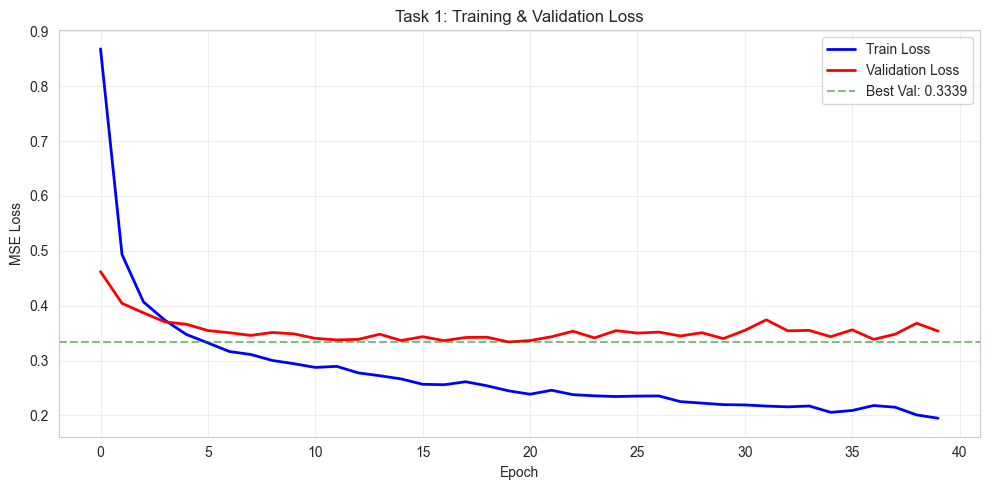



TRAINING TASK 2: Multi-Step Seq2Seq with Attention
Epochs: 100, Patience: 20, LR: 0.001
Teacher Forcing: 0.5, Decay: True
Epoch 01/100: Train = 0.844459 | Val = 0.346319 | TF=0.50 *** Best ***
Epoch 01/100: Train = 0.844459 | Val = 0.346319 | TF=0.50 *** Best ***
Epoch 02/100: Train = 0.354245 | Val = 0.255926 | TF=0.49 *** Best ***
Epoch 02/100: Train = 0.354245 | Val = 0.255926 | TF=0.49 *** Best ***
Epoch 03/100: Train = 0.255250 | Val = 0.219614 | TF=0.49 *** Best ***
Epoch 03/100: Train = 0.255250 | Val = 0.219614 | TF=0.49 *** Best ***
Epoch 04/100: Train = 0.198250 | Val = 0.211770 | TF=0.48 *** Best ***
Epoch 04/100: Train = 0.198250 | Val = 0.211770 | TF=0.48 *** Best ***
Epoch 05/100: Train = 0.165944 | Val = 0.207360 | TF=0.48 *** Best ***
Epoch 05/100: Train = 0.165944 | Val = 0.207360 | TF=0.48 *** Best ***
Epoch 06/100: Train = 0.138766 | Val = 0.185712 | TF=0.47 *** Best ***
Epoch 06/100: Train = 0.138766 | Val = 0.185712 | TF=0.47 *** Best ***
Epoch 07/100: Train = 0.

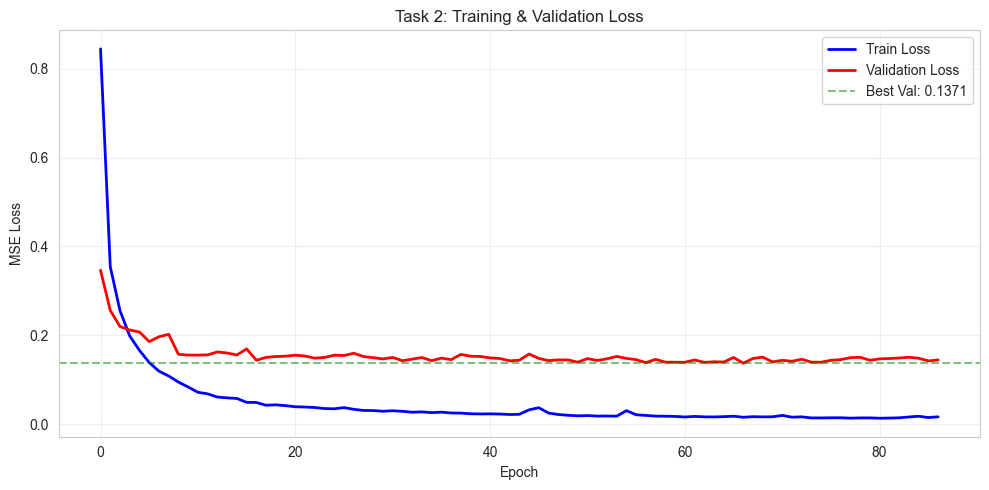


EVALUATING MODELS

Task 1 Test Metrics:
  MSE: 0.3711
  RMSE: 0.6092
  MAE: 0.2506
  NSE: 0.6942
  R2: 0.6942

Task 1 Test Metrics:
  MSE: 0.3711
  RMSE: 0.6092
  MAE: 0.2506
  NSE: 0.6942
  R2: 0.6942


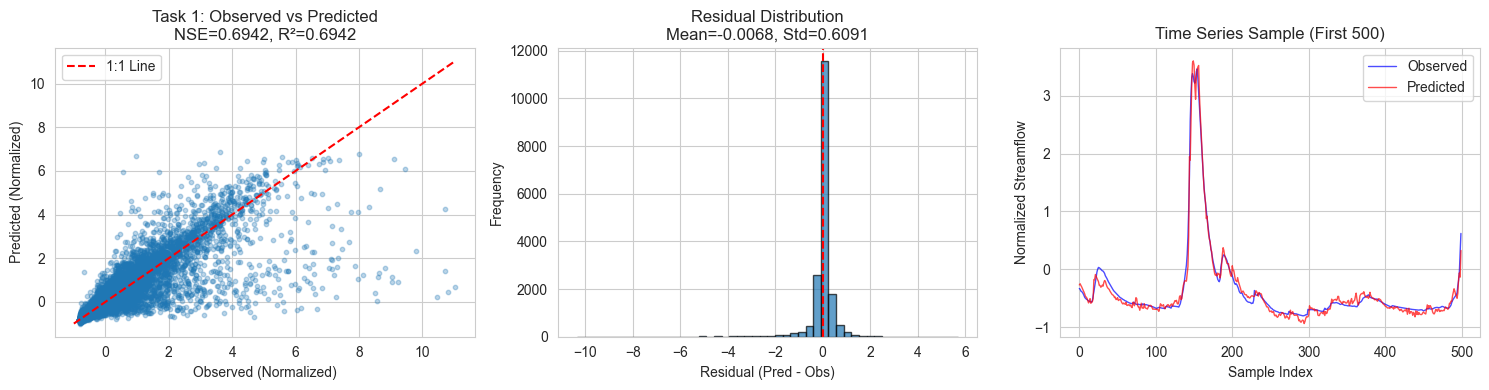


Task 2 Test Metrics (averaged):
  MSE: 0.1602
  RMSE: 0.3988
  MAE: 0.1852
  NSE: 0.8681
  R2: 0.8681


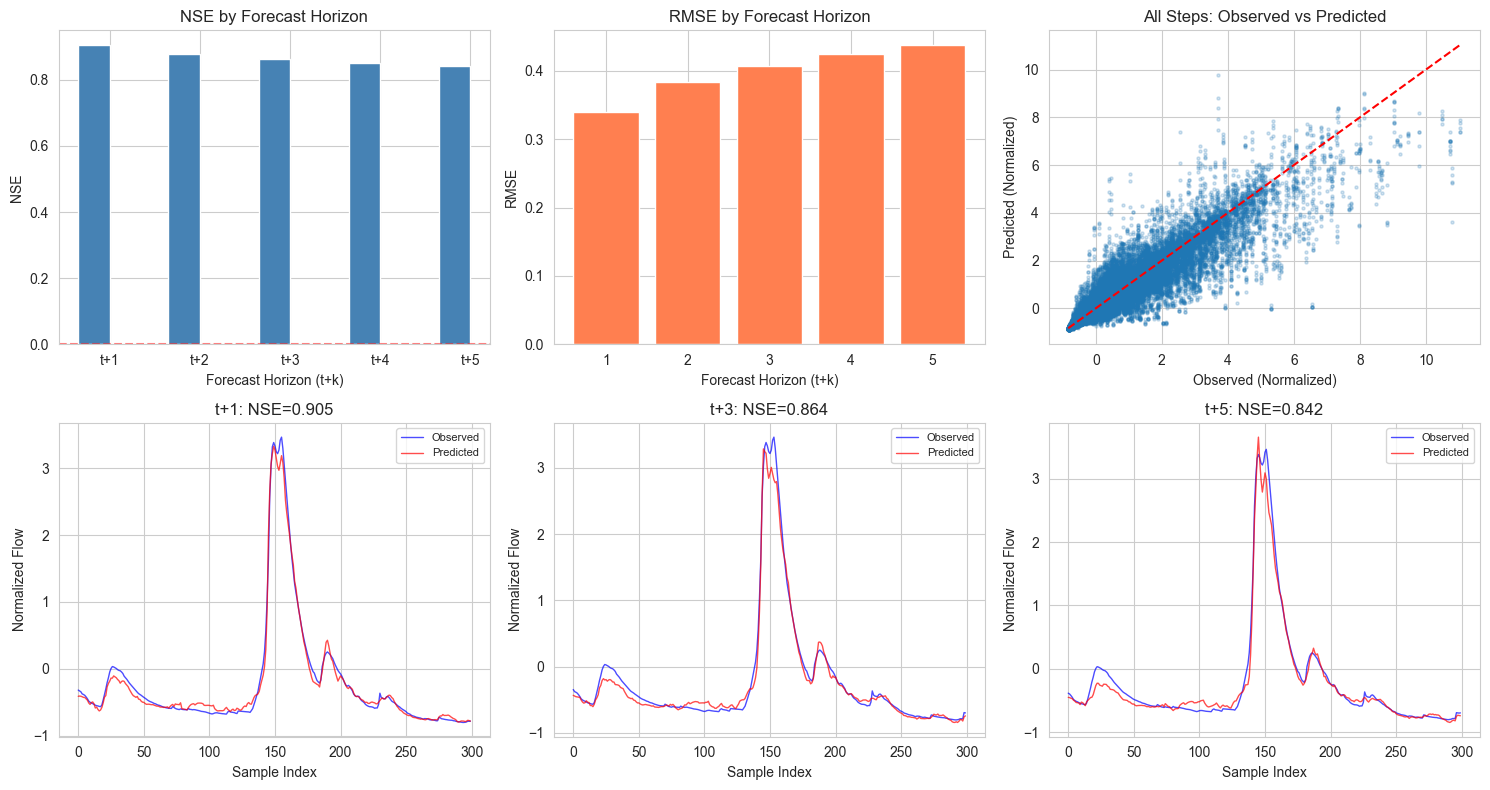

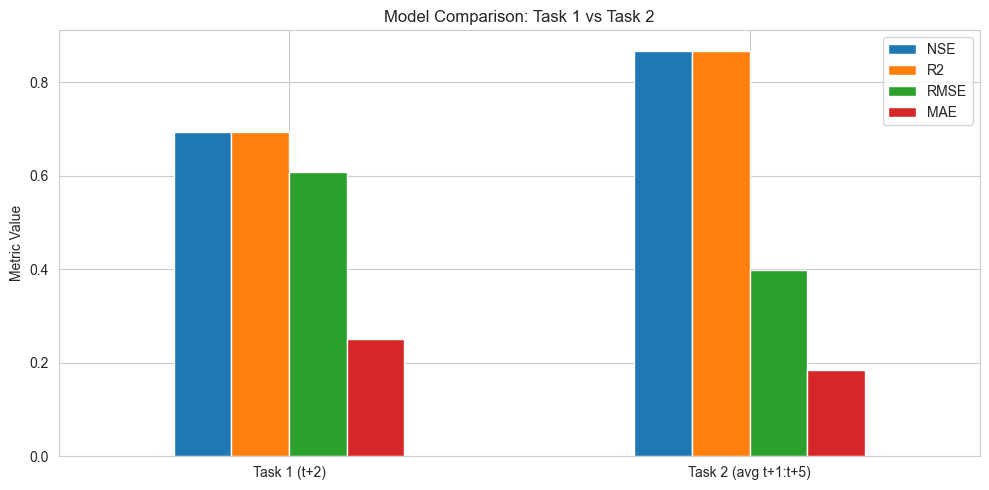


Model Comparison:
                           MSE      RMSE       MAE       NSE        R2
Task 1 (t+2)          0.371068  0.609154  0.250550  0.694197  0.694197
Task 2 (avg t+1:t+5)  0.160181  0.398764  0.185204  0.868079  0.868079
SAVING RESULTS
✓ Models saved to ./results\models
✓ Metrics saved to ./results/metrics.json
✓ Predictions saved to ./results
✓ Training history saved


PIPELINE RESULTS SUMMARY

--- Data ---
Number of basins: 5
Test samples (Task 1): 17955
Test samples (Task 2): 17940

--- Task 1 Metrics (t+2 prediction) ---
  MSE: 0.3711
  RMSE: 0.6092
  MAE: 0.2506
  NSE: 0.6942
  R2: 0.6942

--- Task 2 Metrics (t+1 to t+5 prediction, averaged) ---
  MSE: 0.1602
  RMSE: 0.3988
  MAE: 0.1852
  NSE: 0.8681
  R2: 0.8681

--- Task 2 Metrics Per Horizon ---
  t+1: NSE=0.9045, RMSE=0.3405
  t+2: NSE=0.8783, RMSE=0.3844
  t+3: NSE=0.8638, RMSE=0.4067
  t+4: NSE=0.8513, RMSE=0.4249
  t+5: NSE=0.8425, RMSE=0.4374


In [19]:
# ==============================================================================
# DRIVER CELL - RUN THE FULL PIPELINE
# ==============================================================================
# 
# Modify the PipelineConfig parameters below to run different experiments.
# All settings are controlled from this single location.
#
# ==============================================================================

# --- CONFIGURE YOUR EXPERIMENT ---
cfg = PipelineConfig(
    # === EXPERIMENT SETTINGS ===
    num_basins=5,              # 0 = ALL basins, >0 = limit for quick testing
    use_static=True,           # Include static catchment attributes
    
    # === TRAINING HYPERPARAMETERS ===
    epochs=100,
    batch_size=256,
    learning_rate=0.001,
    dropout=0.2,
    patience=20,
    
    # === TASK 1 MODEL ARCHITECTURE ===
    hidden_dim_t1=16,                   # Smaller for single-step regression
    use_bidirectional_t1=True,          # Bidirectional LSTM
    use_self_attention_t1=True,         # Multi-head self-attention
    num_attention_heads_t1=4,           # Number of attention heads
    use_layer_norm_t1=True,             # Layer normalization
    
    # === TASK 2 MODEL ARCHITECTURE ===
    hidden_dim_t2=64,                   # Larger for seq2seq
    use_bidirectional_encoder_t2=True,  # Bidirectional encoder
    use_self_attention_t2=True,         # Encoder self-attention
    num_attention_heads_t2=4,           # Encoder attention heads
    use_layer_norm_t2=True,             # Layer normalization
    teacher_forcing_ratio=0.5,          # Initial teacher forcing
    tf_decay=True,                      # Decay TF over epochs
    
    # === VISUALIZATION ===
    show_plots=True,           # Set False for batch experiments
    
    # === PATHS ===
    results_dir='./results'
)

# --- RUN THE PIPELINE ---
results = run_full_pipeline(cfg)

# ==============================================================================
# ACCESS RESULTS
# ==============================================================================
# results.model_t1           # Trained Task 1 model (LSTMWithAttention)
# results.model_t2           # Trained Task 2 model (LSTM_Seq2Seq)
# results.metrics_t1         # Task 1 test metrics: {'MSE', 'RMSE', 'MAE', 'NSE', 'R2'}
# results.metrics_t2         # Task 2 test metrics (averaged over 5 steps)
# results.metrics_t2_per_step  # Per-step metrics: {1: {...}, 2: {...}, ...}
# results.predictions_t1     # Task 1 predictions array
# results.predictions_t2     # Task 2 predictions array (N, 5)
# results.history_t1         # Training history: {'train_loss': [...], 'val_loss': [...]}
# results.history_t2         # Training history for Task 2